In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from data_utils import *
from eda_utils import *
from train_utils import *
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
import pickle
import os

import warnings
# Ignore warnings
warnings.filterwarnings("ignore")

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# Data Preprocessing

## Dataset creation

In [3]:
phyt_cod_path = 'data/PHYT_COD_ForDvirLafer.csv'
phyto_path = 'data/Phyto4DvirLafer.csv'

biomass_by_week_year_group = get_biomass_data(phyt_cod_path, phyto_path)

In [4]:
fp_path = 'data/FP_2017_ForDvirLafer.csv'

fp_df = get_fluorprobe_data(fp_path)

## Splitting to test temporarily & Extracting probe's test data

In [5]:
biomass_test = biomass_by_week_year_group[(biomass_by_week_year_group['year'] == 2022) & (biomass_by_week_year_group['month'] >= 3)]
biomass_val = biomass_by_week_year_group[(biomass_by_week_year_group['year'] == 2022) & (biomass_by_week_year_group['month'] < 3)]
biomass_train = biomass_by_week_year_group[(~biomass_by_week_year_group.index.isin(biomass_test.index)) & (~biomass_by_week_year_group.index.isin(biomass_val.index))]

fp_test = fp_df[(fp_df['year'] == 2022) & (fp_df['month'] >= 3)]
fp_val = fp_df[(fp_df['year'] == 2022) & (fp_df['month'] < 3)]
fp_train = fp_df[(~fp_df.index.isin(fp_test.index)) & (~fp_df.index.isin(fp_val.index))]

merged_train = merge_fp_biomass_df(fp_train, biomass_train, is_train=True) # Merging fully
merged_val = merge_fp_biomass_df(fp_val, biomass_val, is_train=False) # Merging fully
merged_test = merge_fp_biomass_df(fp_test, biomass_test, is_train=False) # Merging only closest records by depth

In [6]:
merged_train = merged_train.drop(['Green Algae', 'Bluegreen', 'Diatoms', 'Cryptophyta'], axis=1).reset_index(drop=True)

fluor_groups_map = {
    2: 'Bluegreen',
    3: 'Diatoms',
    4: 'Green Algae',
    6: 'Cryptophyta'
}

fluor_val_df = merged_val[['group_num', 'month', 'week', 'year', 'Depth', 'sum_biomass_ug_ml', 'Green Algae', 'Bluegreen', 'Diatoms', 'Cryptophyta']].reset_index(drop=True)
merged_val = merged_val.drop(['Green Algae', 'Bluegreen', 'Diatoms', 'Cryptophyta'], axis=1).reset_index(drop=True)

fluor_test_df = merged_test[['group_num', 'month', 'week', 'year', 'Depth', 'sum_biomass_ug_ml', 'Green Algae', 'Bluegreen', 'Diatoms', 'Cryptophyta']].reset_index(drop=True)
merged_test = merged_test.drop(['Green Algae', 'Bluegreen', 'Diatoms', 'Cryptophyta'], axis=1).reset_index(drop=True)

In [7]:
biomass_estimation(merged_train)

# EDA and Cleaning

In [8]:
merged_train.shape

(55389, 18)

In [9]:
merged_train = merged_train[merged_train['sum_biomass_ug_ml'] >= 0]

In [10]:
merged_train.shape

(53332, 18)

In [11]:
merged_train.loc[merged_train['Depth'] >= 21, 'Depth'] = 21
merged_val.loc[merged_val['Depth'] >= 21, 'Depth'] = 21
merged_test.loc[merged_test['Depth'] >= 21, 'Depth'] = 21

In [12]:
signals = ['red', 'green', 'yellow', 'orange', 'violet', 'brown', 'blue', 'pressure', 'temp_sample', 'yellow_sub', 'sum_biomass_ug_ml']

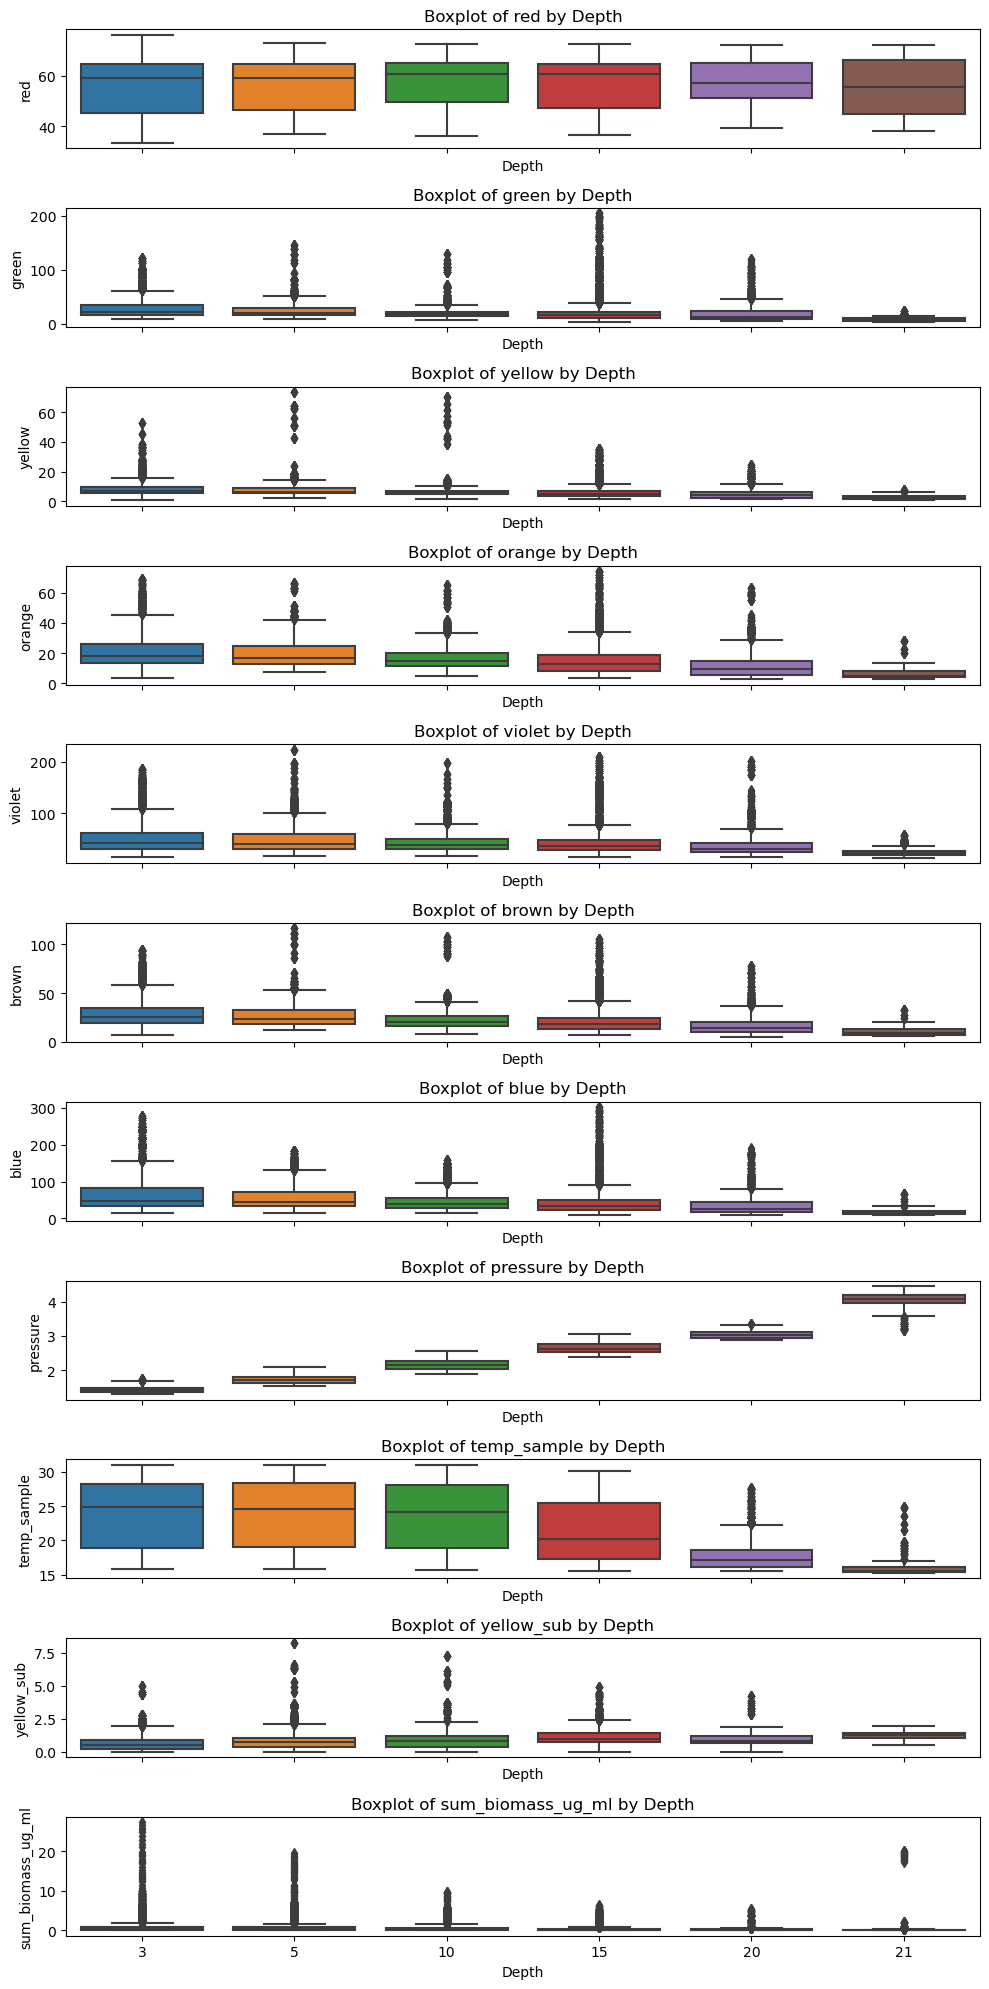

In [13]:
boxplot_by_depth(merged_train, signals, by_col='Depth')

In [14]:
signals.remove('sum_biomass_ug_ml')
signals.remove('pressure')
signals.remove('temp_sample')
boundaries = {
    'red': {'lower_bound': 0, 'upper_bound': 120},
    'green': {'lower_bound': 0, 'upper_bound': 100},
    'yellow': {'lower_bound': 0, 'upper_bound': 40},
    'orange': {'lower_bound': 0, 'upper_bound': 60},
    'violet': {'lower_bound': 0, 'upper_bound': 150},
    'brown': {'lower_bound': 0, 'upper_bound': 80},
    'blue': {'lower_bound': 0, 'upper_bound': 220},
    'yellow_sub': {'lower_bound': 0, 'upper_bound': 7}
}

filter_signals_by_boundaries(merged_train, signals, boundaries)

In [15]:
merged_train.shape

(52368, 18)

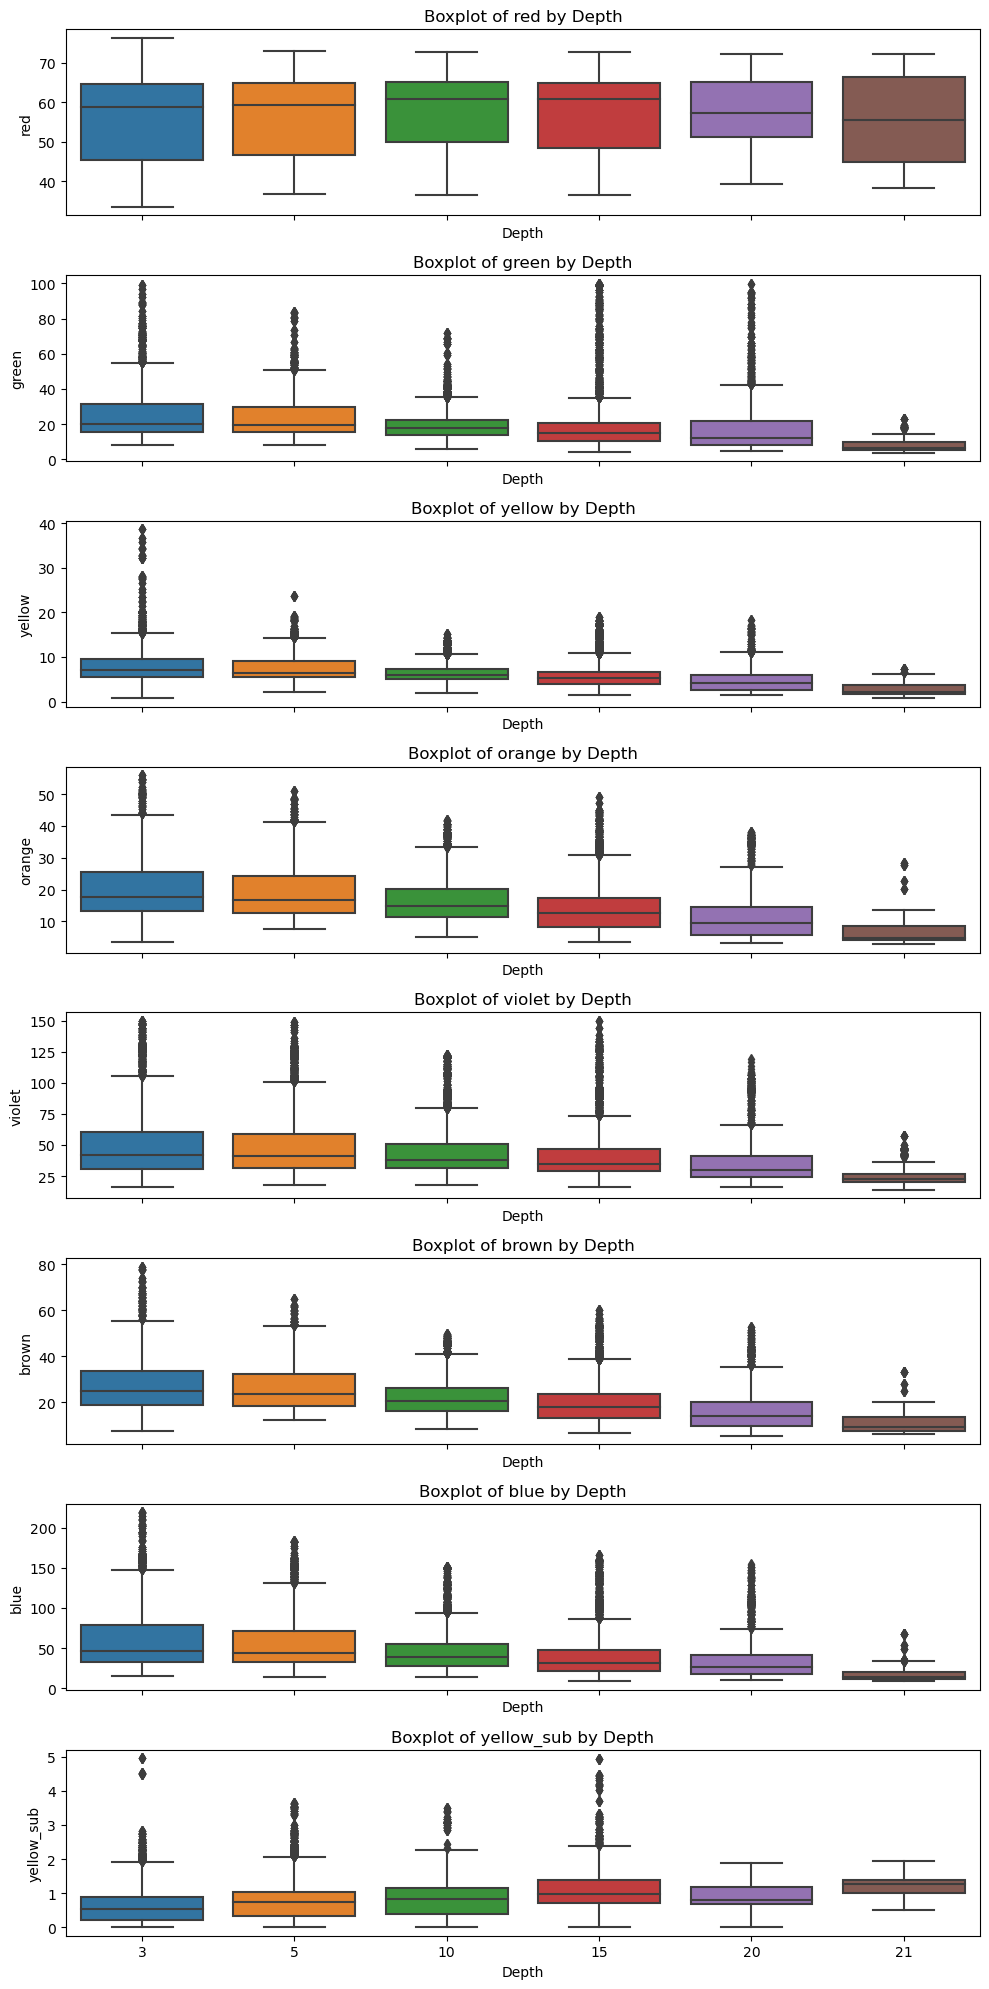

In [16]:
boxplot_by_depth(merged_train, signals, by_col='Depth')

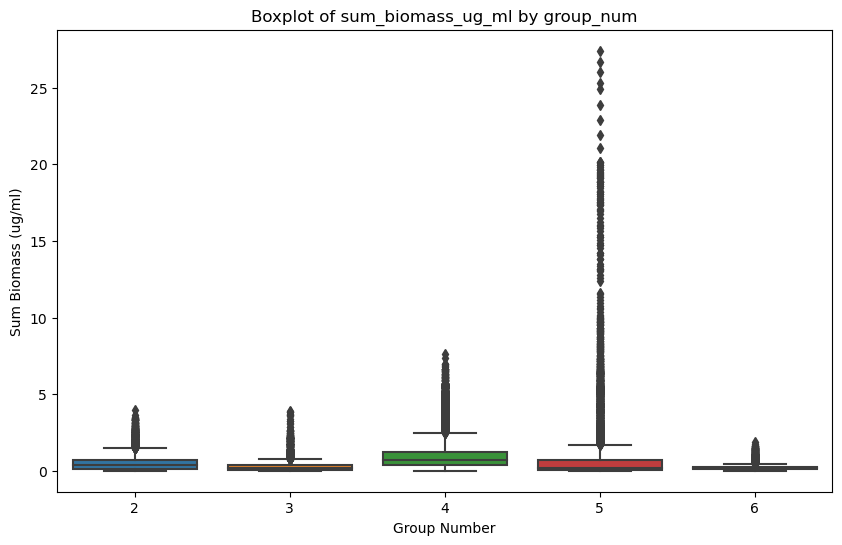

In [17]:
boxplot_biomass_by_group(merged_train)

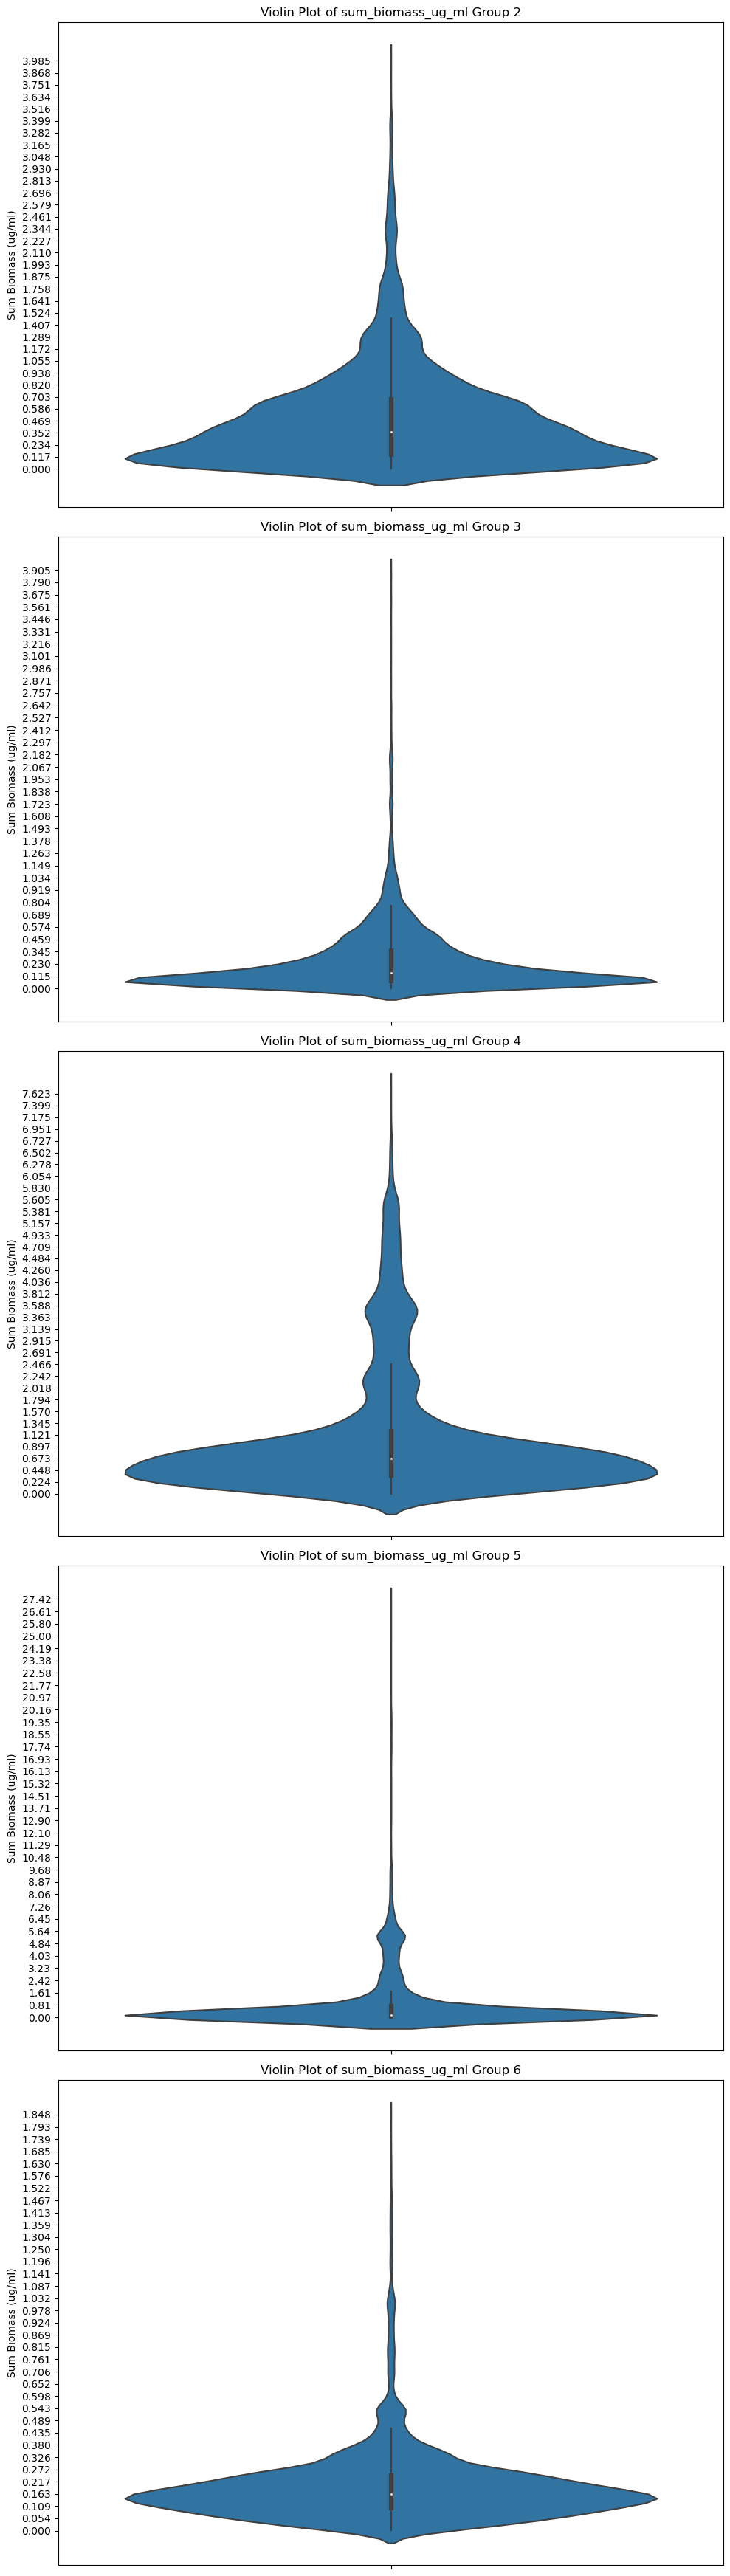

In [18]:
violin_biomass_by_group(merged_train)

In [19]:
# ranges_dict = {
#     2: (0, 0.5, 0.5),
#     3: (0, 0.3, 0.6),
#     4: (0.1, 1, 0.6),
#     5: (0, 0.8, 0.6),
#     6: (0, 0.25, 0.6)
# }

# undersample_merged = undersample_within_ranges(merged_train, ranges_dict)

In [20]:
# undersample_merged.shape

In [21]:
# merged_train.shape

In [22]:
# violin_biomass_by_group(undersample_merged)

In [23]:
# boundaries = {
#     2: (0.1, 2.5),
#     3: (0, 2),
#     4: (0, 5),
#     5: (0, 3),
#     6: (0.02, 1)
# }

# filter_biomass_by_group_boundaries(merged_train, boundaries)

In [24]:
# merged_train.shape

In [25]:
# undersample_merged['sum_biomass_ug_ml'] = undersample_merged['sum_biomass_ug_ml'].apply(np.log)
# boxplot_biomass_by_group(undersample_merged)
# undersample_merged['sum_biomass_ug_ml'] = undersample_merged['sum_biomass_ug_ml'].apply(np.exp)

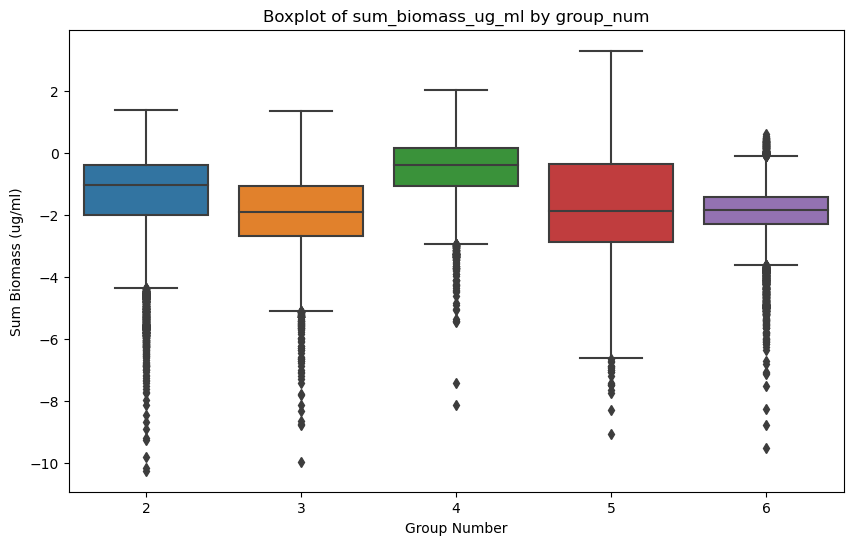

In [26]:
merged_train['sum_biomass_ug_ml'] = merged_train['sum_biomass_ug_ml'].apply(np.log)
boxplot_biomass_by_group(merged_train)

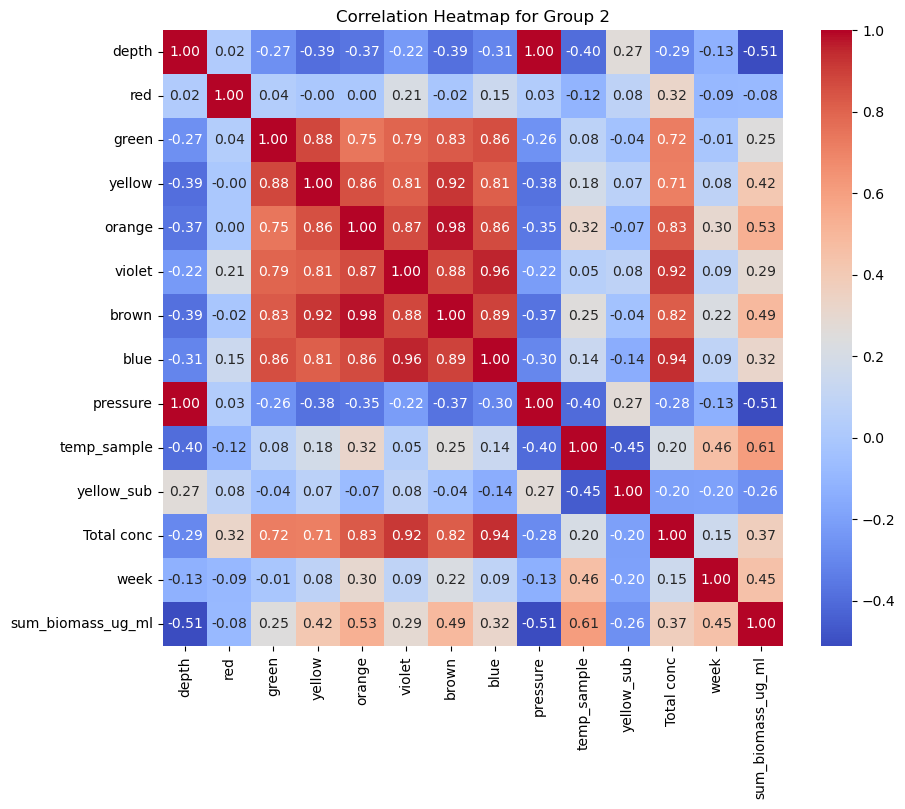

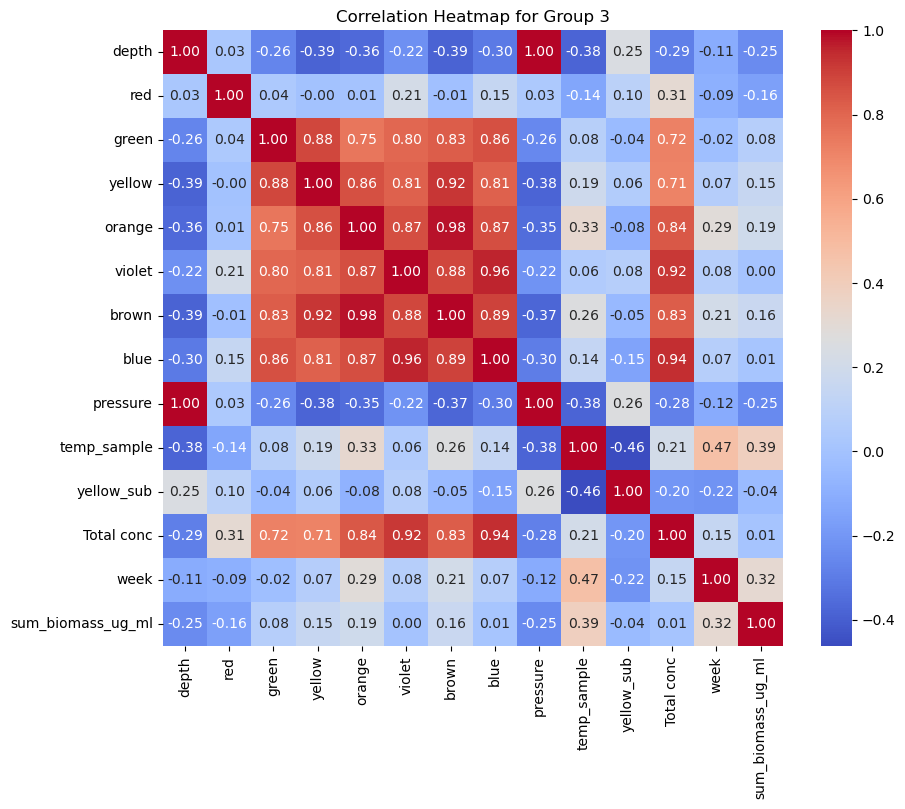

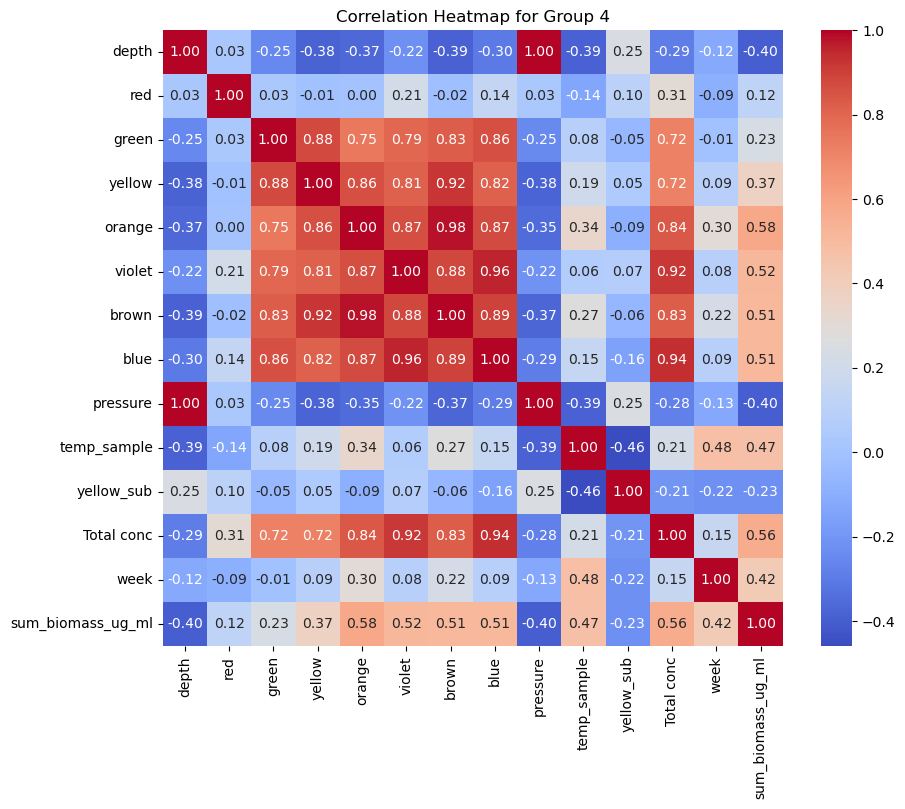

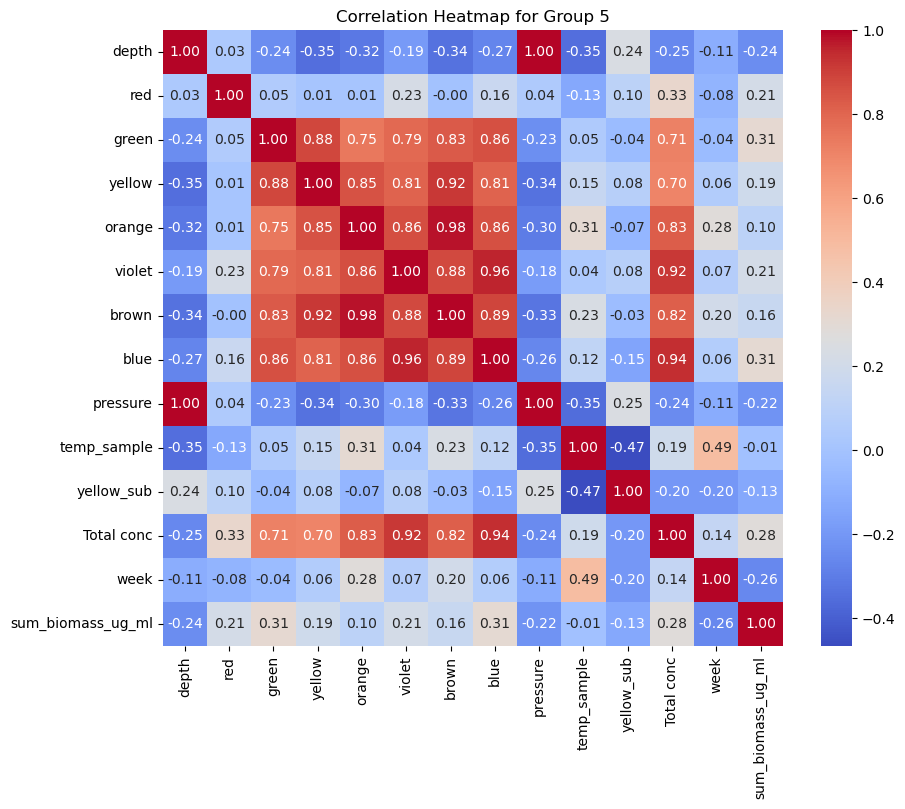

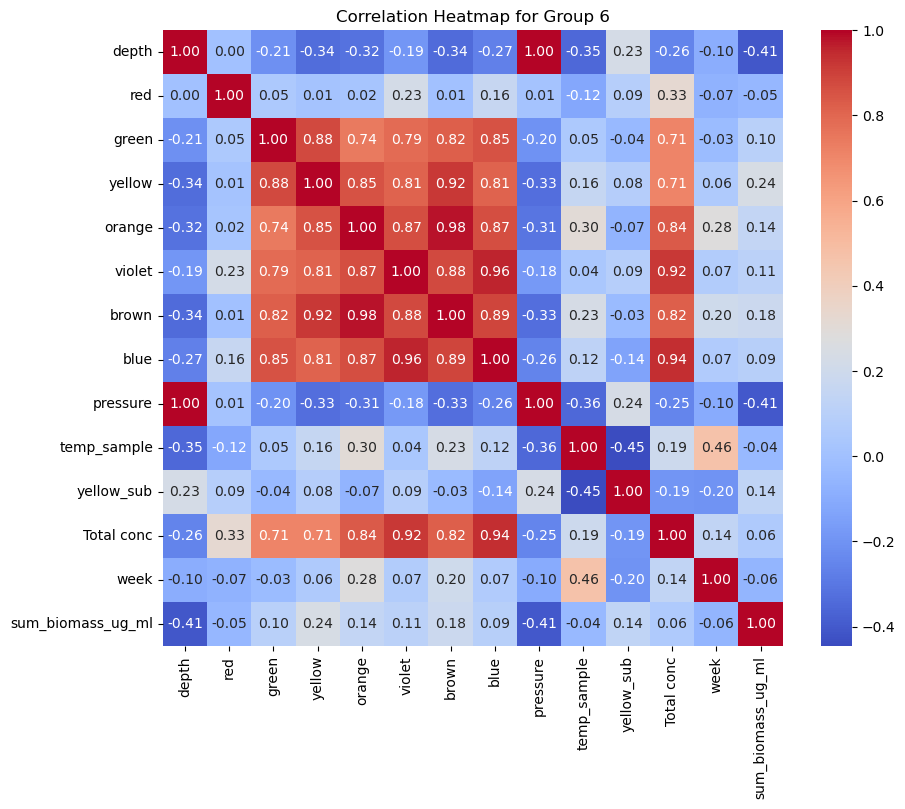

In [27]:
correlation_per_group(merged_train)

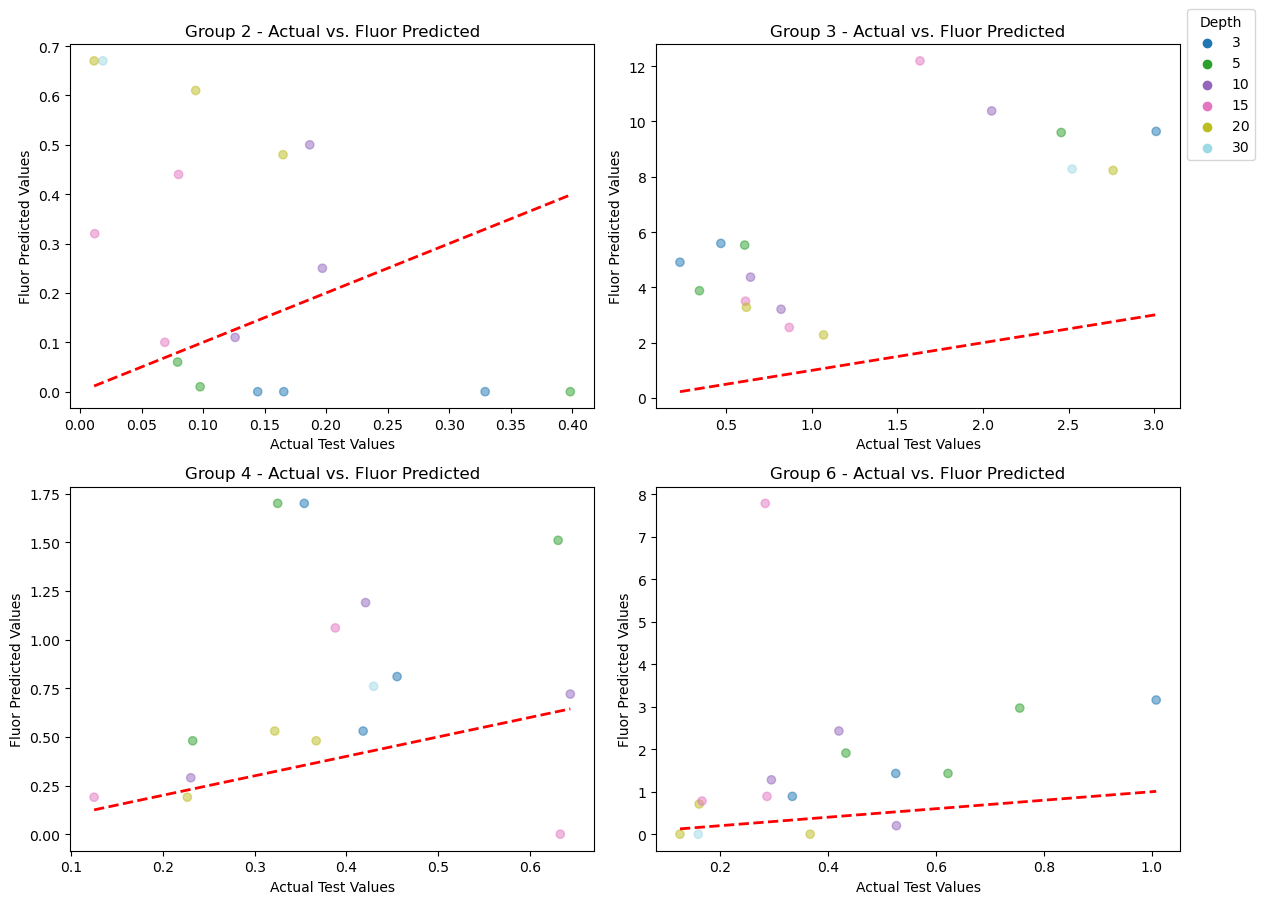

In [28]:
plot_fluorprobe_prediction(fluor_val_df, fluor_groups_map)

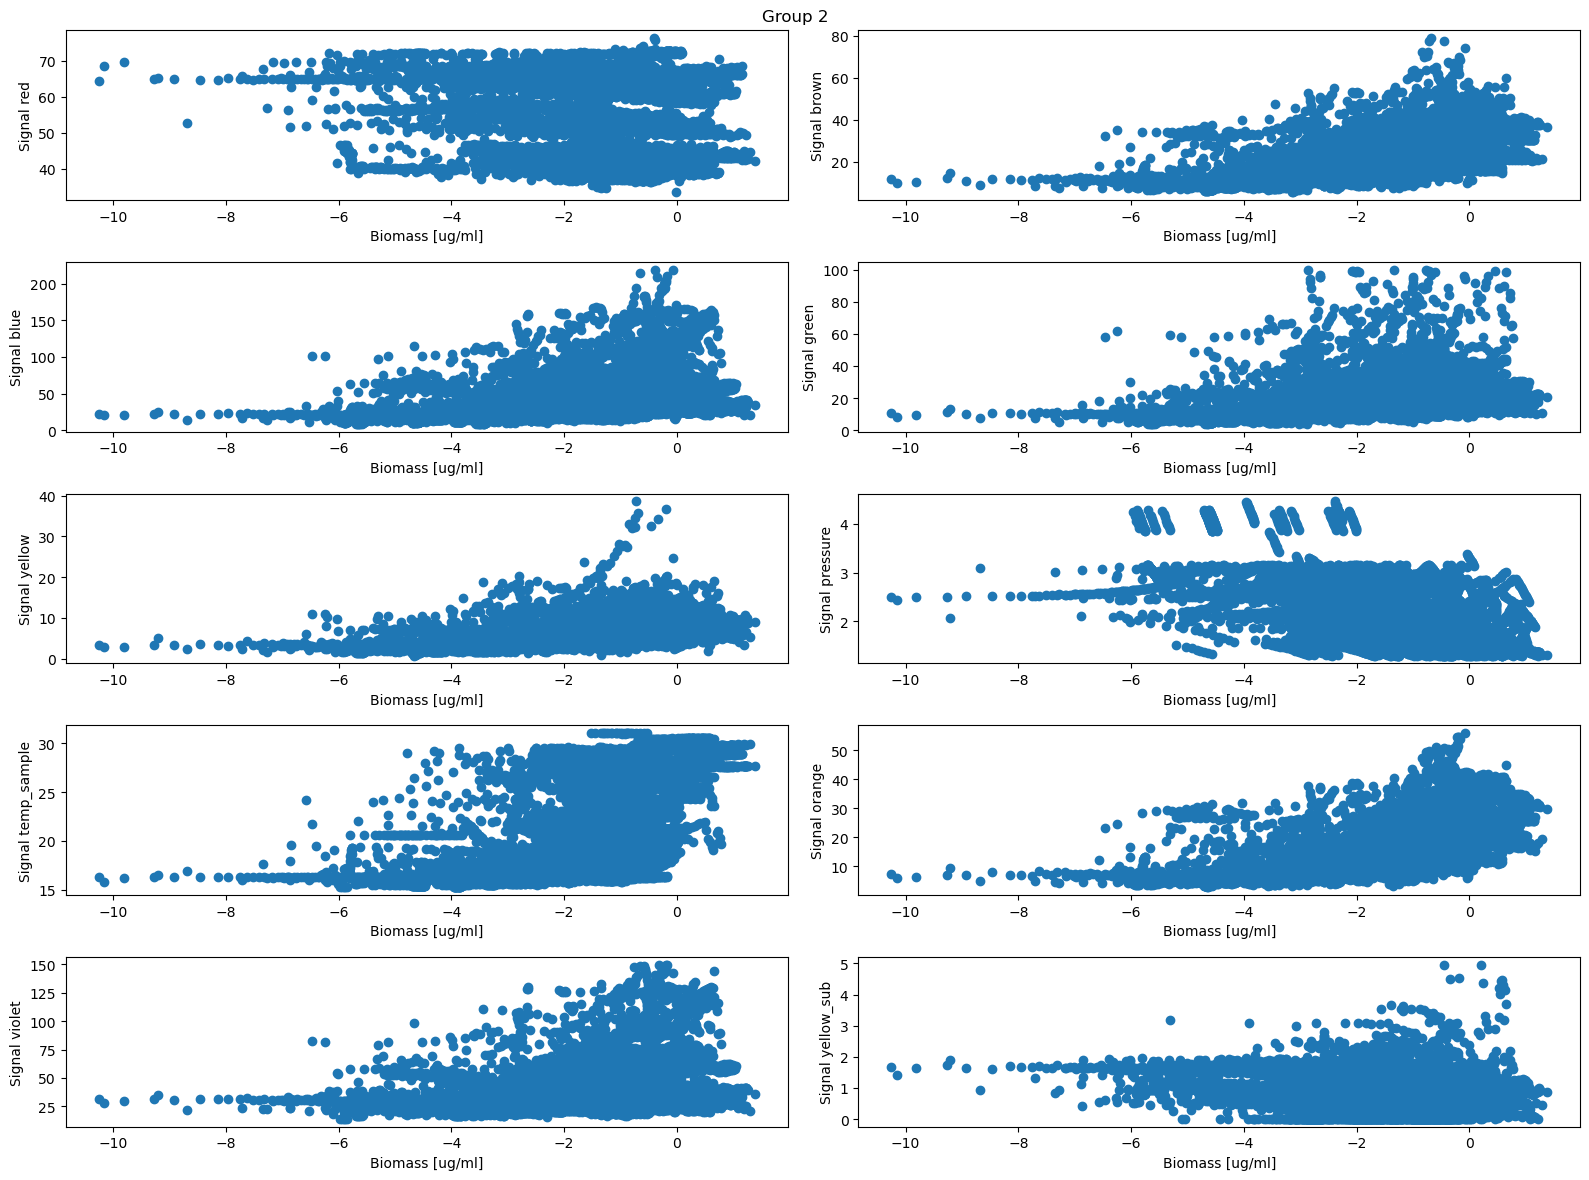

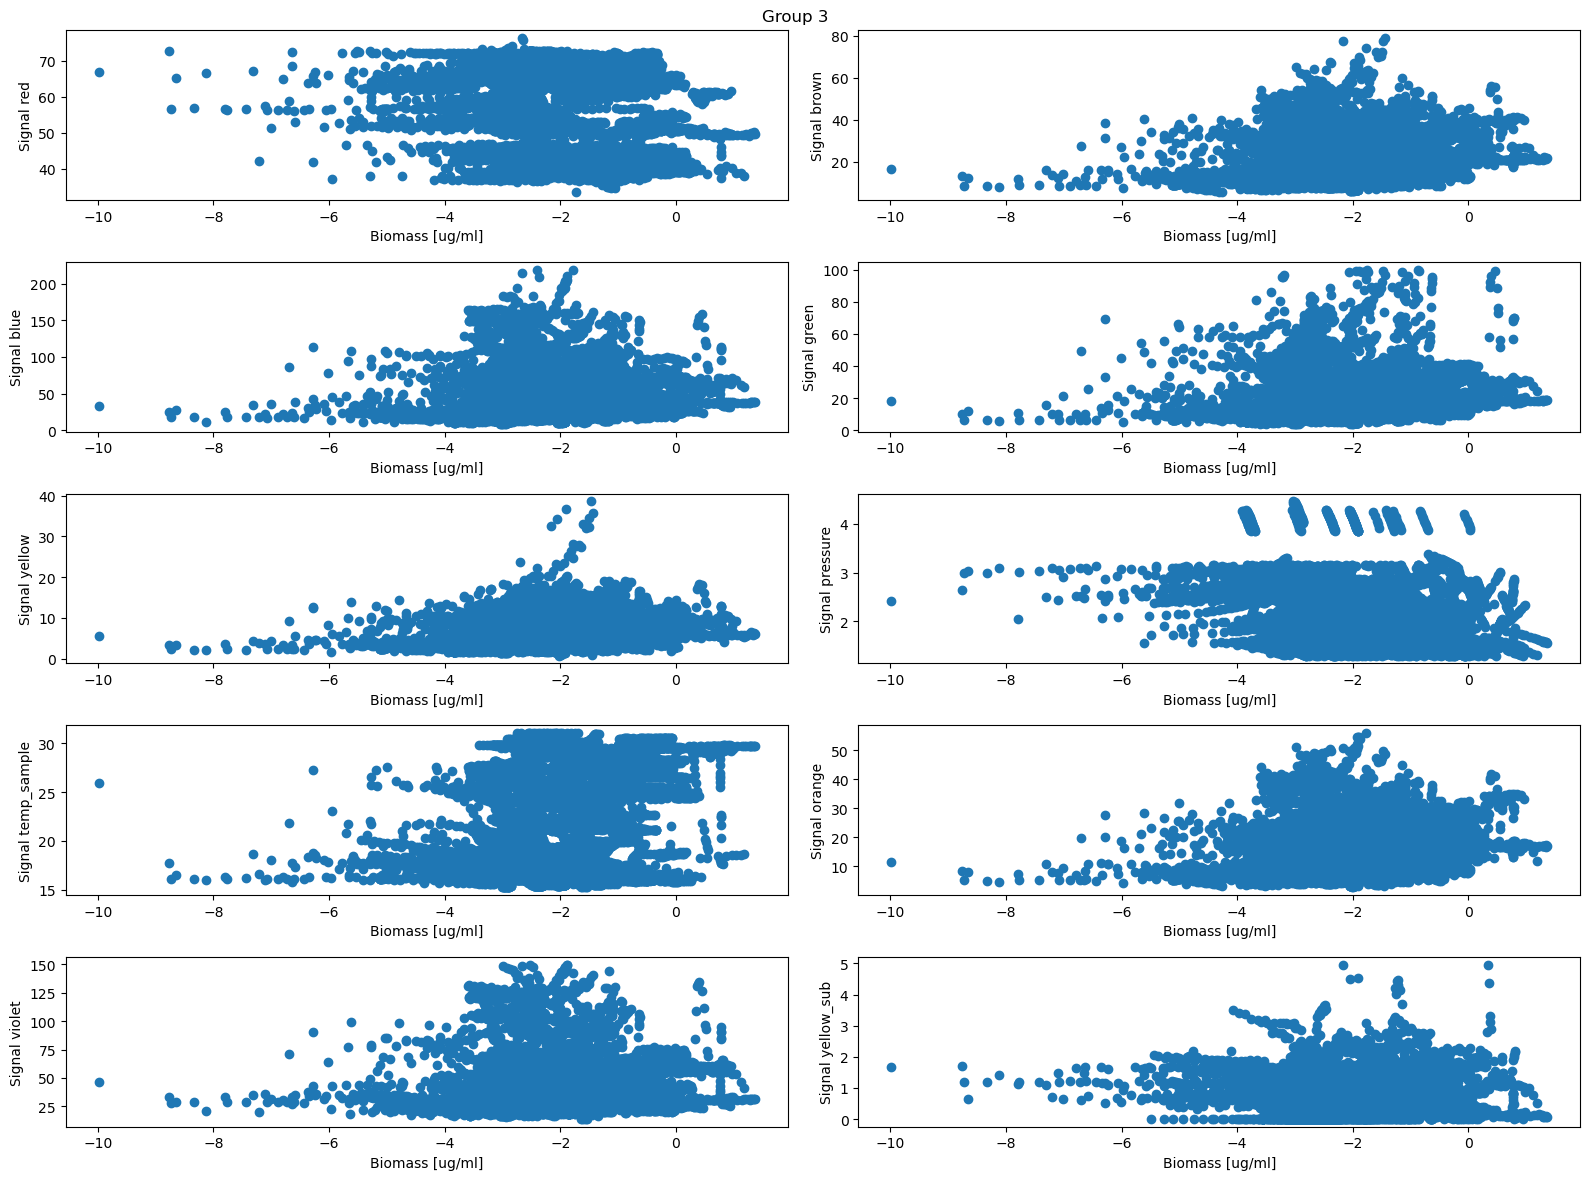

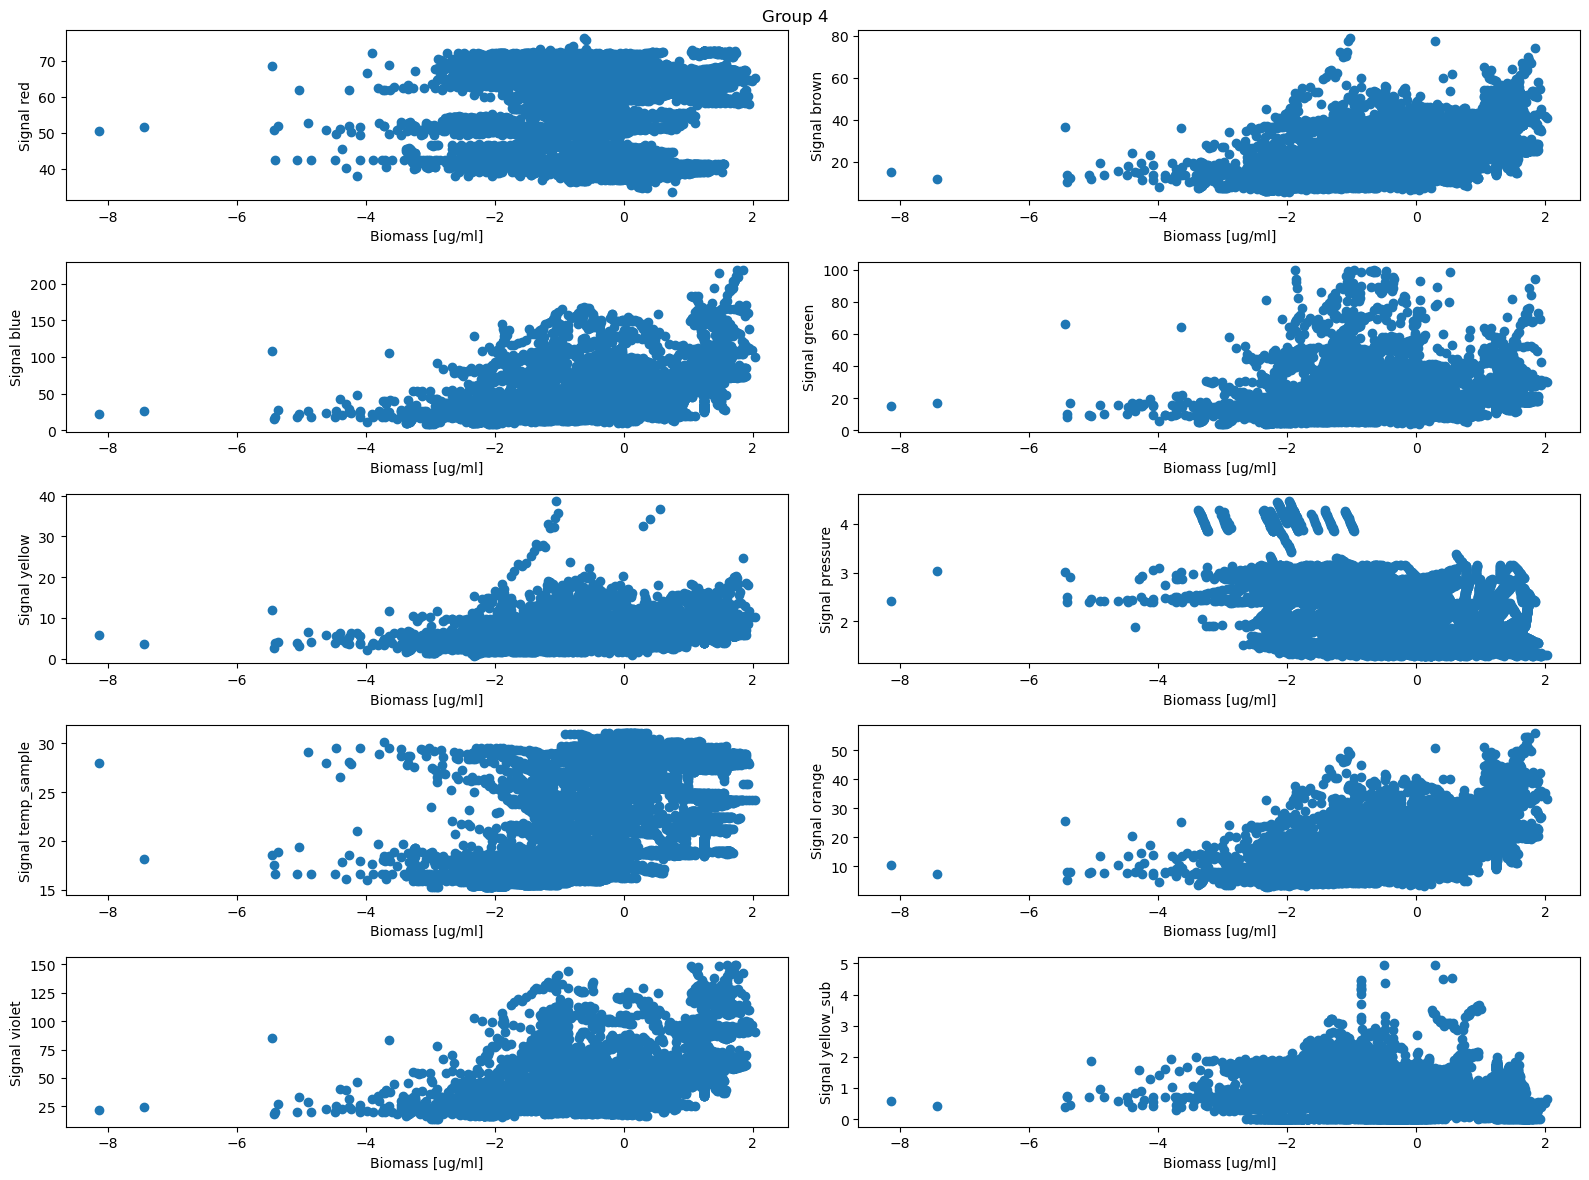

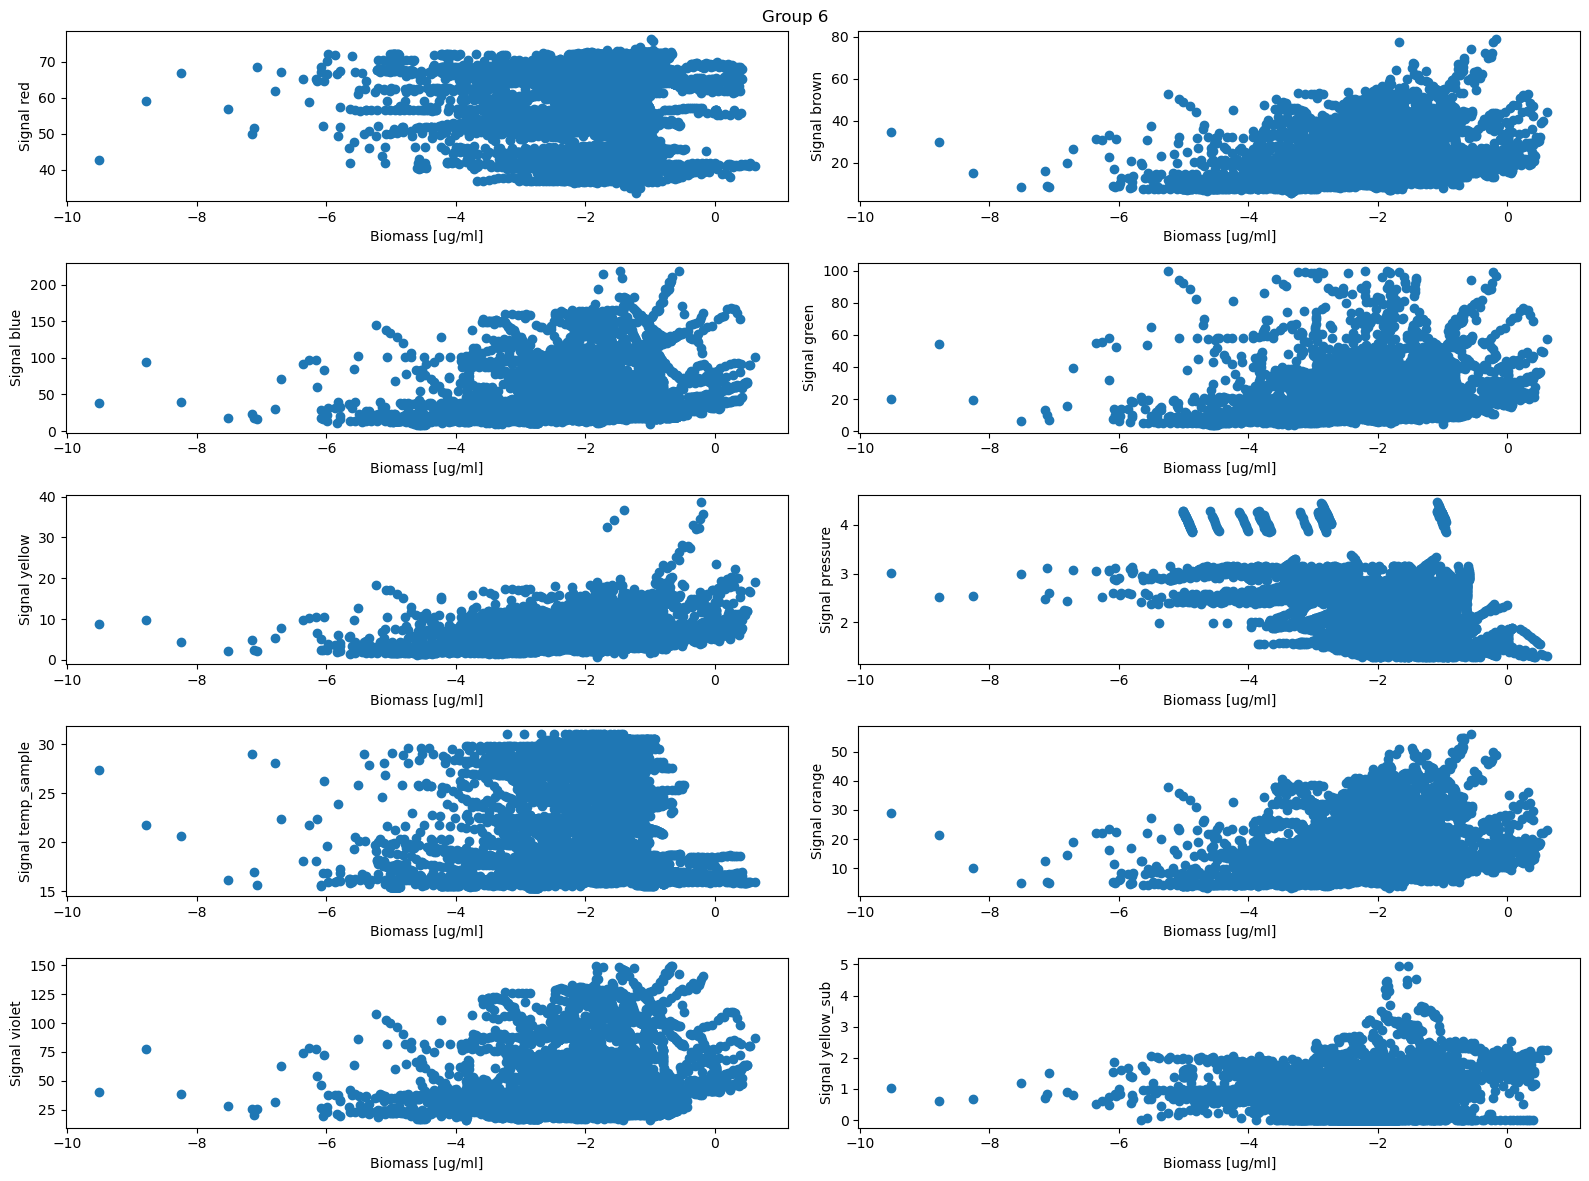

In [29]:
plot_corr_per_feature_per_group(merged_train, fluor_groups_map)

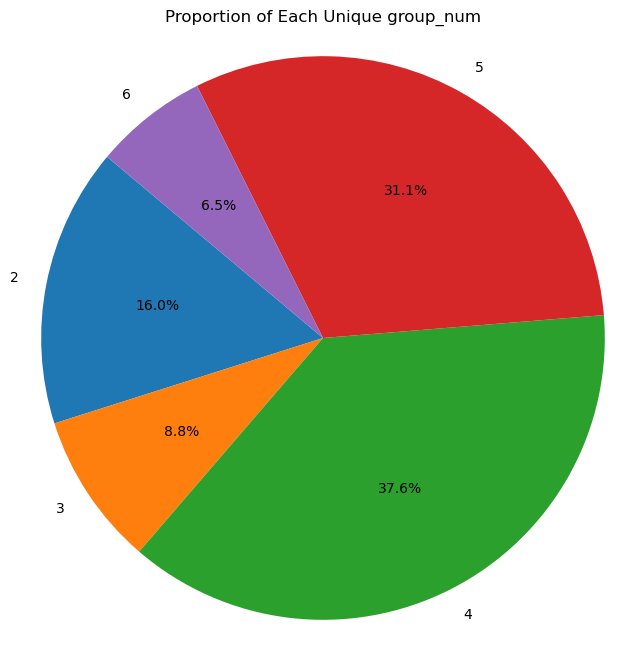

In [30]:
merged_train['sum_biomass_ug_ml'] = merged_train['sum_biomass_ug_ml'].apply(np.exp)
groups_pie_chart(merged_train, by_biomass=True)

In [31]:
merged_train = merged_train.drop(['year', 'Depth', 'depth', 'week', 'month'], axis=1)
# undersample_merged = undersample_merged.drop(['year', 'Depth', 'depth', 'week', 'month'], axis=1)
# merged_test = merged_test.drop(['year', 'Depth', 'week', 'depth_discrete', 'month'], axis=1)
# merged_val = merged_val.drop(['year', 'Depth', 'week', 'depth_discrete', 'month'], axis=1)

# Training models and evaluating

In [32]:
pickled_params = 'best_grid_params.pkl'
do_search = not os.path.exists(pickled_params)

def two_scorer(mse=False):
    score = mean_squared_error if mse else r2_score
    return make_scorer(score, greater_is_better=mse==False)

In [33]:
if do_search:
#     param_grid_per_model = {'xgb': {
#         "model__n_estimators": [100, 300, 500], # Number of boosting rounds
#         "model__learning_rate": [0.01, 0.1, 0.2], # Step size shrinkage
#         "model__max_depth": [3, 5, 7, 11], # Maximum depth of a tree,
#         'model__min_child_weight': [1, 5, 7],  # Minimum sum of instance weight needed in a child
#         "model__subsample": [0.2, 0.5, 1.0], # Fraction of samples used for fitting trees
#         "model__colsample_bytree": [0.2, 0.8, 1.0] # Fraction of features used for fitting trees
#     },
#     'svr':  {
#         "model__C": [0.1, 1, 10, 100], # Regularization parameter
#         "model__kernel": ["poly", "rbf"],
#         "model__degree": [1, 2, 3], # Degree of the polynomial kernel (for "poly" kernel)
#         "model__epsilon": [0.01, 0.1, 0.2], # Epsilon in the epsilon-SVR loss function
#         "model__tol": [1e-4, 1e-3, 1e-2] # Tolerance for stopping criterion
#     },
#     'elf': {
#         "model__alpha": [0.01, 0.1, 1, 10], # Regularization parameter
#         "model__l1_ratio": [0.2, 0.5, 0.8], # Mixing parameter between L1 and L2 regularization
#         "model__fit_intercept": [True, False], # Whether to calculate the intercept for the model
#     }}
    param_grid_per_model = {'xgb': {
        "model__n_estimators": [100, 300, 500], # Number of boosting rounds
        "model__max_depth": [2, 3, 5], # Maximum depth of a tree,
        "model__alpha": [0.01, 0.1, 1, 10], # L1 regularization term
        "model__lambda": [0, 0.2, 0.8], # Mixing parameter between L1 and L2 regularization
    },
    'svr':  {
        "model__C": [0.001, 0.1, 1, 10, 100], # Regularization parameter
        "model__tol": [1e-4, 1e-3, 1e-2] # Tolerance for stopping criterion
    },
    'elf': {
        "model__alpha": [0.01, 0.1, 1, 10], # Regularization parameter
        "model__l1_ratio": [0.2, 0.5, 0.8], # Mixing parameter between L1 and L2 regularization
    }}
    
    best_group_params_per_model = {}
    for model_name, param_grid in param_grid_per_model.items():
        best_group_params_per_model[model_name] = grid_search_cv(model_name, merged_train, param_grid=param_grid,
                                                                scoring_method=two_scorer(mse=True))
    
    with open(pickled_params, 'wb') as f:
        pickle.dump(best_group_params_per_model, f)
    
    best_group_params_per_model_fixed = {}
    for model_name, kwargs_per_group in best_group_params_per_model.items():
        best_group_params_per_model_fixed[model_name] = {}
        for group_num in kwargs_per_group.keys():
            best_group_params_per_model_fixed[model_name][group_num] = {}
            kwargs = kwargs_per_group[group_num]
            for param, val in kwargs.items():
                fixed_param = param.split('model__')[1]
                best_group_params_per_model_fixed[model_name][group_num][fixed_param] = val


    with open(pickled_params, 'wb') as f:
        pickle.dump(best_group_params_per_model_fixed, f)

else:
    with open(pickled_params, 'rb') as f:
        best_group_params_per_model_fixed = pickle.load(f)

In [34]:
regression_models = {}
for model_name, best_group_params_fixed in best_group_params_per_model_fixed.items():
    regression_models[model_name], _ = train(model_name, merged_train, group_kwargs=best_group_params_per_model_fixed, test_size=0.0,
                                             biomass_fn=np.log)
    

regression_models['lr'], _ = train('lr', merged_train, test_size=0.0, biomass_fn=np.log)

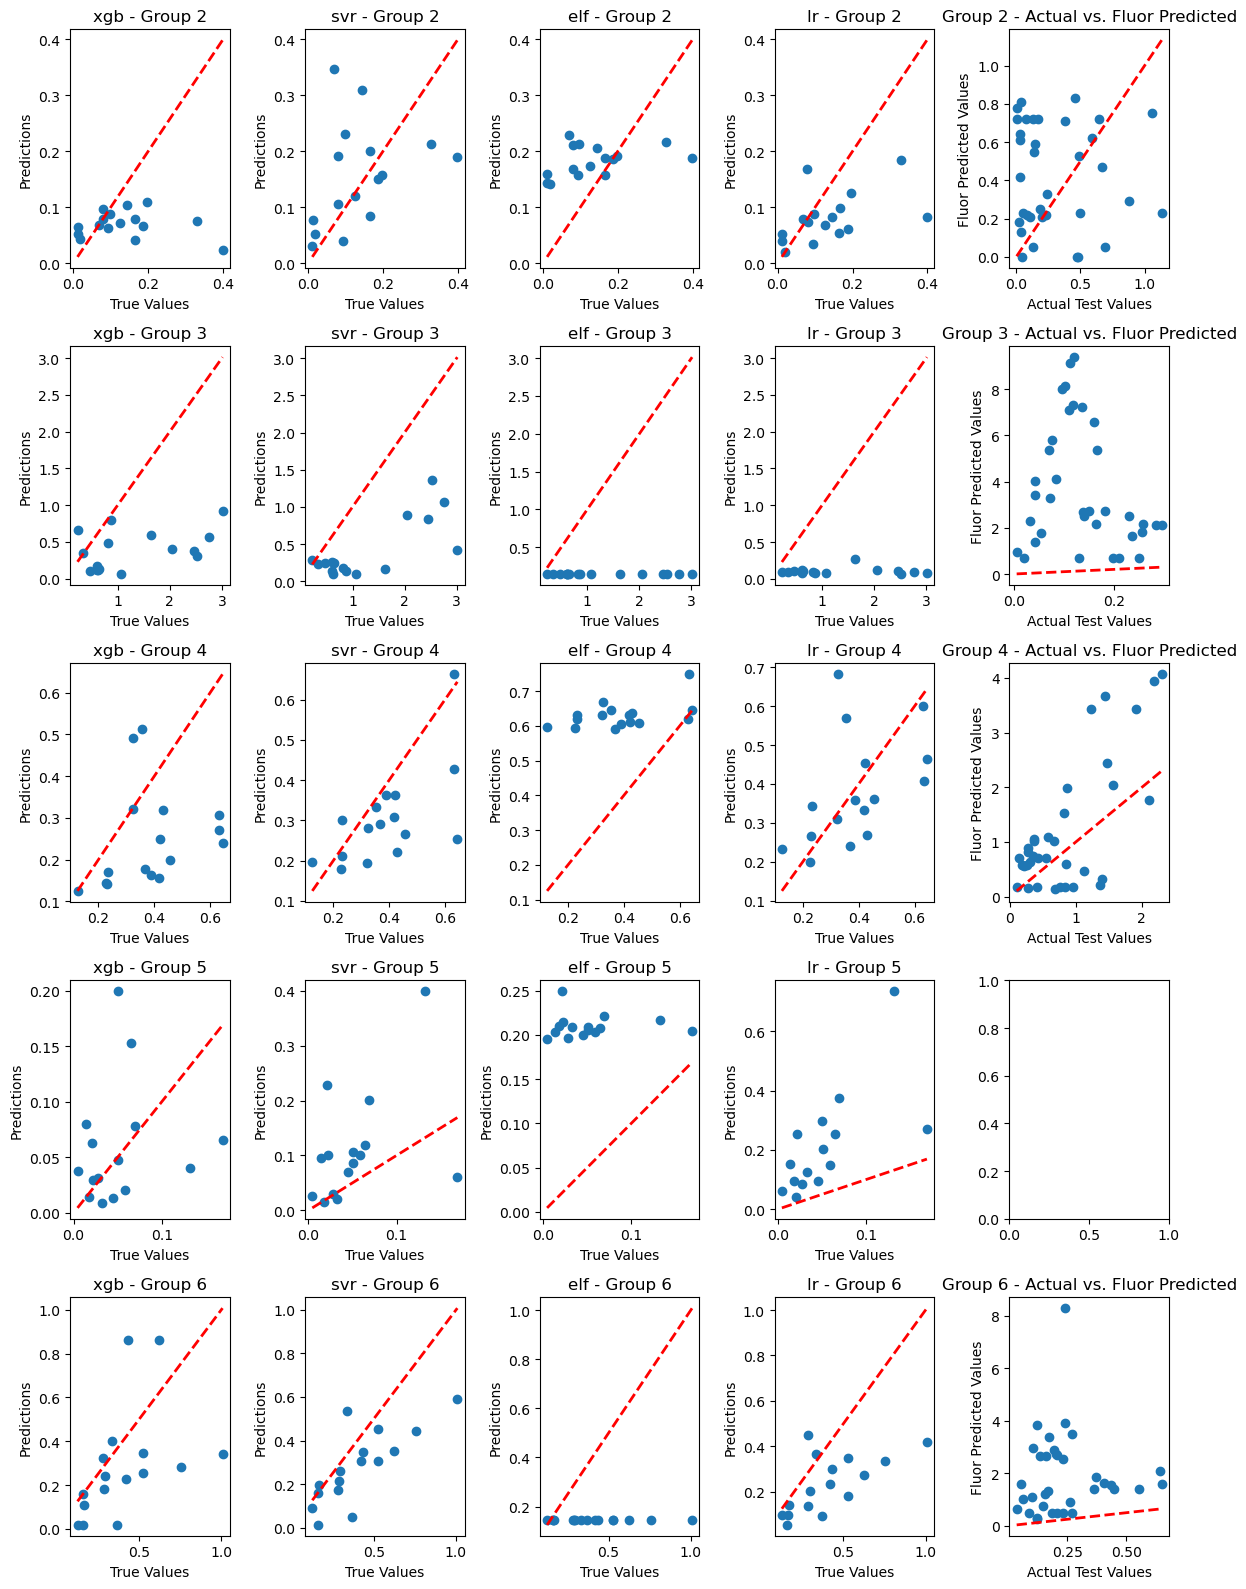

In [35]:
comparing_df = compare_all_models(regression_models, merged_val.drop(['year', 'Depth', 'week', 'month'], axis=1), fluor_test_df, fluor_groups_map, predictions_fn=np.exp)

In [36]:
comparing_df.groupby('Model').mean()[['RMSE', 'MAPE']]

,RMSE,MAPE
Model,,
FP,2.010829,16.578301
elf,0.473684,2.487776
lr,0.444846,1.370567
svr,0.334022,0.948679
xgb,0.384518,0.821281


In [43]:
comparing_df[comparing_df['Model'] == 'xgb']

,Group,Model,RMSE,R-squared,MAPE
0,2,xgb,0.127450,-0.501130,0.930965
5,3,xgb,1.240809,-0.804148,0.747041
10,4,xgb,0.214083,-1.112759,0.416210
15,5,xgb,0.062941,-1.096242,1.517554
19,6,xgb,0.277307,-0.420070,0.494635


In [37]:
# eval_test(regression_models['svr'], merged_test, prediction_fn=np.exp)

In [40]:
from functools import partial

# Function to predict biomass using the corresponding model for each row
def predict_biomass(row, model_name):
    trained_model = regression_models[model_name][row['group_num']]
    features = row[['red', 'green', 'yellow', 'orange', 'violet', 'brown', 'blue', 'pressure', 'temp_sample', 'yellow_sub', 'Total conc']]
    return np.exp(trained_model.predict([features])[0])

# Apply the predict_biomass function to each row and add the results as a new column
merged_val['predicted_biomass'] = merged_val.apply(partial(predict_biomass, model_name='xgb'), axis=1)

In [47]:
mean_squared_error(merged_val[merged_val['group_num'] == 4]['sum_biomass_ug_ml'], merged_val[merged_val['group_num'] == 4]['predicted_biomass'], squared=False)

0.2140833069850137

In [51]:
merged_val_true_pivot = pivot_merged_df(merged_val)
merged_val_predicted_pivot = pivot_merged_df(merged_val, pivot_col='predicted_biomass')

In [53]:
proportionalize(merged_val_true_pivot, row_proportional_cols=[2, 3, 4, 5, 6])

In [59]:
y_true_proportions = merged_val_true_pivot[[2,3,4,5,6]].values

In [60]:
proportionalize(merged_val_predicted_pivot, row_proportional_cols=[2, 3, 4, 5, 6])
y_predicted_proportions = merged_val_predicted_pivot[[2,3,4,5,6]].values

In [63]:
mean_proportion_error(y_true_proportions, y_predicted_proportions)

267.4639359780449

In [65]:
proportionalize(fluor_val_df)
fluor_val_df

,group_num,month,week,year,Depth,sum_biomass_ug_ml,Green Algae,Bluegreen,Diatoms,Cryptophyta
0,2,1,1,2022,3,0.329222,5.711207,0.000000,60.237069,34.051724
1,2,1,1,2022,5,0.079301,5.309735,0.663717,61.172566,32.853982
2,2,1,1,2022,10,0.196956,3.950954,3.405995,59.536785,33.106267
3,2,1,1,2022,15,0.080102,3.784861,8.764940,69.721116,17.729084
4,2,1,1,2022,20,0.164985,4.077253,10.300429,70.386266,15.236052
...,...,...,...,...,...,...,...,...,...,...
74,6,2,8,2022,3,0.525440,11.328671,0.000000,68.671329,20.000000
75,6,2,8,2022,5,0.622265,22.140762,0.000000,56.891496,20.967742
76,6,2,8,2022,10,0.294913,20.552677,1.899827,55.440415,22.107081
77,6,2,8,2022,15,0.166289,22.505308,6.794055,54.140127,16.560510


In [73]:
fluor_val_df = fluor_val_df[['week', 'month', 'year', 'Depth', 'Green Algae', 'Bluegreen', 'Diatoms', 'Cryptophyta']].drop_duplicates()
fluor_val_df

,week,month,year,Depth,Green Algae,Bluegreen,Diatoms,Cryptophyta
0,1,1,2022,3,5.711207,0.000000,60.237069,34.051724
1,1,1,2022,5,5.309735,0.663717,61.172566,32.853982
2,1,1,2022,10,3.950954,3.405995,59.536785,33.106267
3,1,1,2022,15,3.784861,8.764940,69.721116,17.729084
4,1,1,2022,20,4.077253,10.300429,70.386266,15.236052
24,6,2,2022,3,13.900245,0.000000,78.822567,7.277187
25,6,2,2022,5,12.859304,0.075643,72.617247,14.447806
26,6,2,2022,10,6.101695,4.237288,87.966102,1.694915
27,6,2,2022,15,0.000000,0.498008,60.707171,38.794821
28,6,2,2022,20,5.656350,6.510139,87.833511,0.000000


In [80]:
mean_proportion_error(y_true_proportions, fluor_val_df[['Green Algae', 'Bluegreen', 'Diatoms', 'Cryptophyta']].values)

1409.8946045073396